#  CIFAR-10 image classification with CNN

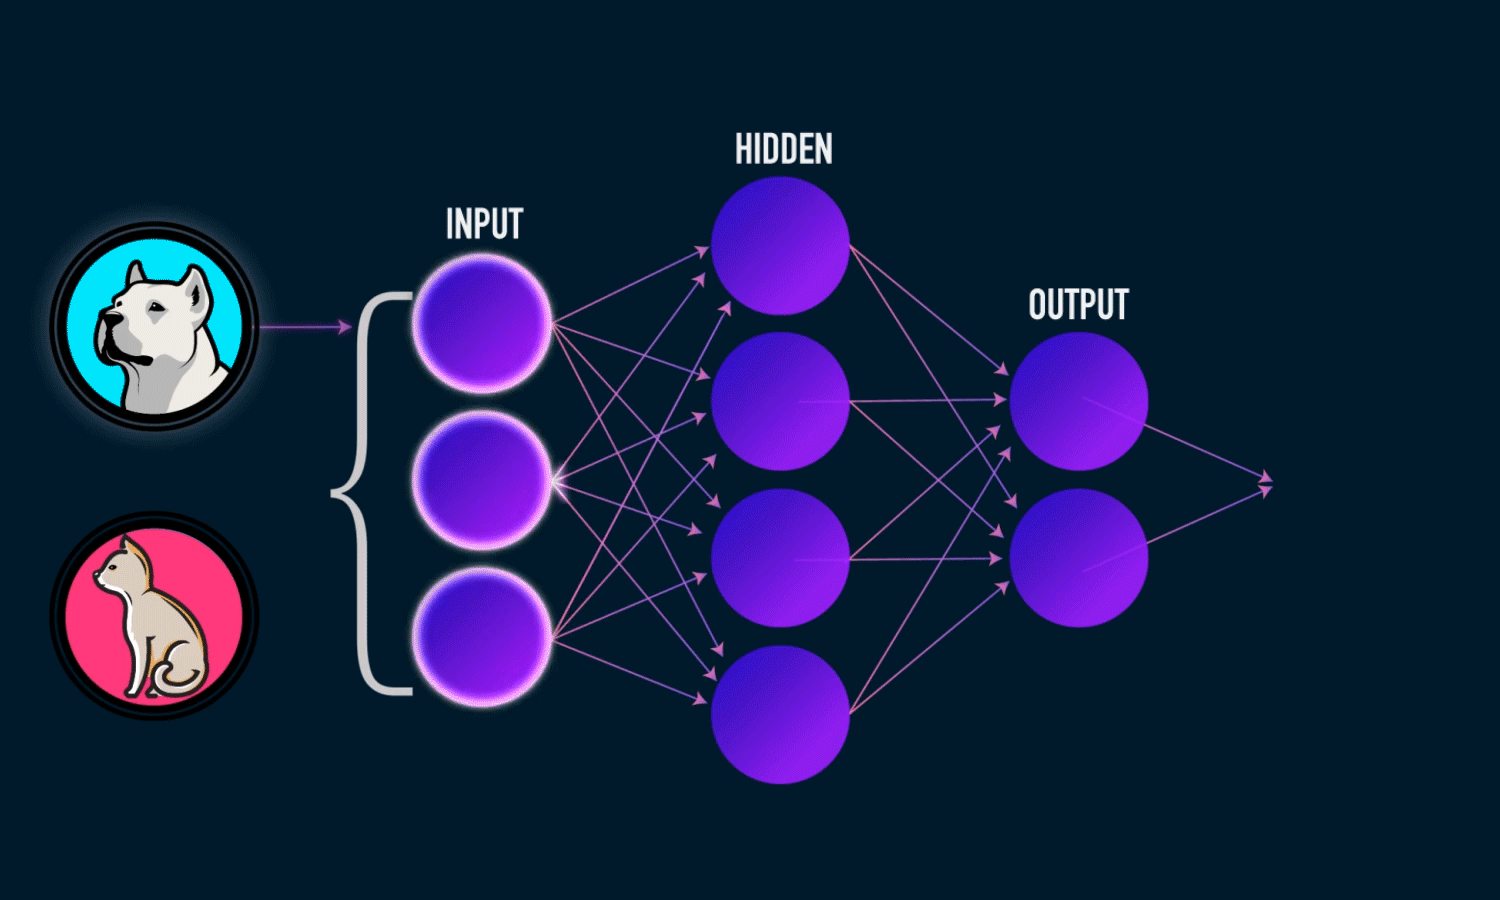

In [1]:
!pip3 install torch torchvision

In [2]:
import numpy as np
import pandas as pd
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
torch.__version__

'1.8.0+cu101'

## 1. Import & process dataset
- CIFAR10 dataset can be downloaded by ```torchvision```
  - [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

train_dataset = datasets.CIFAR10(root = "/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "/", train = False, download = True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## 2. Creating CNN model and training

- Create and train simple CNN model

![](https://www.researchgate.net/profile/Qianzhou_Du2/publication/322477802/figure/fig3/AS:582461356511232@1515881017676/Illustration-of-Convolutional-Neural-Network-CNN-Architecture.png)

In [4]:
# create data loaders 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [5]:
%%html
<iframe src="https://poloclub.github.io/cnn-explainer/" width="1200" height="1000"></iframe>

$output = \frac{input−K+2P}{S+1}$

with $K$ = kernel size, $S$ = stride

In [6]:
# create CNN with one convolution/pooling layer
class net(nn.Module):
  def __init__(self, input_dim, num_filters, kernel_size, stride, padding, num_classes):
    super(net, self).__init__()
    self.input_dim = input_dim
    conv_output_size = int((input_dim - kernel_size + 2 * padding)/stride) + 1   # conv layer output size
    pool_output_size = int((conv_output_size - kernel_size)/stride) + 1          # pooling layer output size
    
    self.conv = nn.Conv2d(3, num_filters, kernel_size = kernel_size, stride = stride, padding = padding)     
    self.pool = nn.MaxPool2d(kernel_size = kernel_size, stride = stride)
    self.relu = nn.ReLU()
    self.dense = nn.Linear(pool_output_size * pool_output_size * num_filters, num_classes)     
    
  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)   # resize to fit into final dense layer
    x = self.dense(x)
    return x

In [7]:
# hyperparameters
DEVICE = torch.device('cuda')
INPUT_DIM = 32
NUM_FILTERS = 32
KERNEL_SIZE = 3
STRIDE = 1
PADDING = 1
NUM_CLASSES = 10
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30              

In [8]:
model = net(INPUT_DIM, NUM_FILTERS, KERNEL_SIZE, STRIDE, PADDING, NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()   # do not need softmax layer when using CEloss criterion
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [12]:
# training for NUM_EPOCHS
for i in range(NUM_EPOCHS):
  temp_loss = []
  for (x, y) in train_loader:
    x, y = x.float().to(DEVICE), y.to(DEVICE)
    outputs = model(x)
    loss = criterion(outputs, y)
    temp_loss.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  print("Loss at {}th epoch: {}".format(i, np.mean(temp_loss)))

Loss at 0th epoch: 0.5992775102862922
Loss at 1th epoch: 0.5897636774098477
Loss at 2th epoch: 0.5678742016520342
Loss at 3th epoch: 0.5469381454045815
Loss at 4th epoch: 0.5353958875017093
Loss at 5th epoch: 0.5162966644672482
Loss at 6th epoch: 0.5057331524084291
Loss at 7th epoch: 0.488122640592058
Loss at 8th epoch: 0.47318490562231647
Loss at 9th epoch: 0.4638504278476891
Loss at 10th epoch: 0.44745318877422596
Loss at 11th epoch: 0.4286346389052203
Loss at 12th epoch: 0.41743303869691345
Loss at 13th epoch: 0.40875662184889666
Loss at 14th epoch: 0.39734325567474754
Loss at 15th epoch: 0.3838471996662257
Loss at 16th epoch: 0.37278316838814474
Loss at 17th epoch: 0.3593223551502618
Loss at 18th epoch: 0.3477377943370653
Loss at 19th epoch: 0.342644820166061
Loss at 20th epoch: 0.326058488710762
Loss at 21th epoch: 0.32013320286408103
Loss at 22th epoch: 0.3052924058931258
Loss at 23th epoch: 0.302874181467249
Loss at 24th epoch: 0.2972139627351176
Loss at 25th epoch: 0.2863723885

In [ ]:
for (x, y) in train_loader:
  def closure():
    x, y = x.float().to(DEVICE), y.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(x)
    loss = loss_fn(outputs, y)
    loss.backward()
    return loss
  optimizer.step(closure)


Some optimization algorithms such as **Conjugate Gradient** and **LBFGS** need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model. The closure should clear the gradients, compute the loss, and return it.

Example:

## 3. Evaluation
- Evaluate the trained CNN model with accuracy score 
  - Store probability of each instance to a list and compare it with true y label

In [13]:
y_pred, y_true = [], []
with torch.no_grad():
  for x, y in test_loader:
    x, y = x.float().to(DEVICE), y.to(DEVICE)
    outputs = F.softmax(model(x)).max(1)[-1]       # predicted label
    y_true += list(y.cpu().numpy())                # true label
    y_pred += list(outputs.cpu().numpy())   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [14]:
# evaluation result
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6313

In [ ]:
msikaroudi@uwaterloo.ca